In [1]:
## Install Dependencies
!pip install pandas numpy matplotlib seaborn scikit-learn joblib tensorflow keras

In [2]:
## Import Dependencies
from locale import normalize
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline
sns.set(color_codes= True)

import joblib
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [3]:
# set random seed for reproduciblity
np.random.seed(10)
tf.random.set_seed(10)

## Data source 
### 1. Download datasets from https://github.com/BLarzalere/LSTM-Autoencoder-for-Anomaly-Detection
### 2. make 'data' folder to save the datasets

In [9]:
## Dataset loading
def data_load():
    data_dir= 'data/bearing_data'
    merged_data= pd.DataFrame()

    for filename in os.listdir(data_dir):
        dataset= pd.read_csv(os.path.join(data_dir, filename), sep='\t')
        dataset_mean_abs= np.array(dataset.abs().mean())
        dataset_mean_abs= pd.DataFrame(dataset_mean_abs.reshape(1,4))
        dataset_mean_abs.index= [filename]
        merged_data= pd.concat([merged_data, dataset_mean_abs], axis=0)

    merged_data.columns= ['Bearing_1', 'Bearing_2', 'Bearing_3', 'Bearing_4']

    ## Transform data file index to datetime and sort in chronological order
    merged_data.index= pd.to_datetime(merged_data.index, format= '%Y.%m.%d.%H.%M.%S')
    merged_data= merged_data.sort_index()
    merged_data.to_csv('Averaged_BearingTest_dataset.csv')
    print("Dataset shape:", merged_data.shape)

    ## Data split
    train= merged_data['2004-02-12 10:52:39':'2004-02-15 12:52:39']
    test= merged_data['2004-02-15 12:52:39':]
    return train, test

In [10]:
train, test= data_load()

Dataset shape: (982, 4)


In [11]:
print("dataset for training shape : ", train.shape)
print("datset for testing shape : ", test.shape)

dataset for training shape :  (445, 4)
datset for testing shape :  (538, 4)


In [12]:
## visaulize dataset
def data_vis(train):
    fig, ax= plt.subplots(figsize= (14,6), dpi=80)
    ax.plot(train['Bearing_1'], label='Bearing 1', color='blue', linewidth=1)
    ax.plot(train['Bearing_2'], label='Bearing 2', color='red', linewidth=1)
    ax.plot(train['Bearing_3'], label='Bearing 3', color='green', linewidth=1)
    ax.plot(train['Bearing_4'], label='Bearing 4', color='black', linewidth=1)
    plt.legend(loc='lower left')
    ax.set_title('Bearing Sensor Training Data', fontsize= 16)
    plt.show()

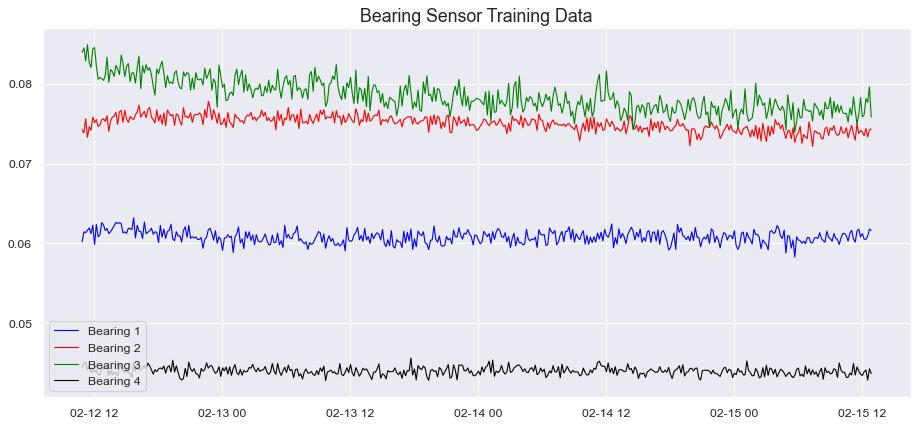

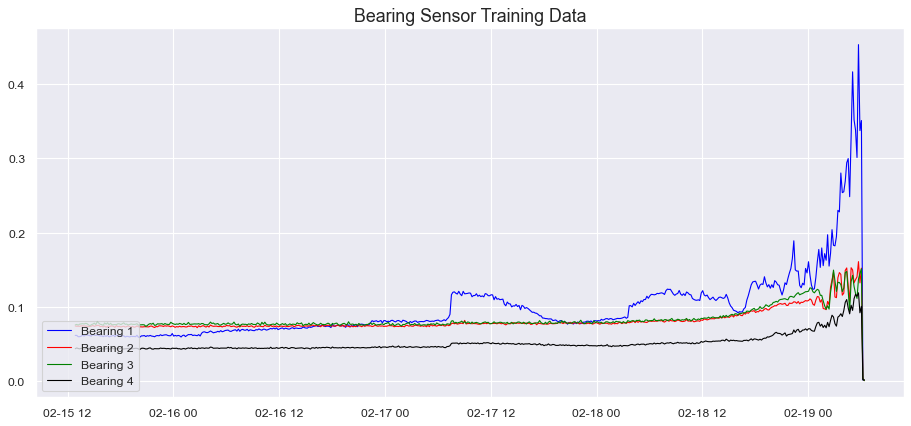

In [14]:
data_vis(train)
data_vis(test)

## Standardizing data

In [16]:
## Standardizing data means that data is mapped into normal distribution.
## This helps data to be trained more effectively.

def normalize_data(train, test):
    mean= train.mean()
    std= train.std()
    X_train= np.array((train - mean) / std)
    X_test= np.array((test - mean) / std)
    return X_train, X_test

In [17]:
## Reshaping data for training LSTM model
def reshape_data(X_train, X_test):
    ## Reshape inputs for LSTM [samples, timesteps, features]
    X_train= X_train.reshape(X_train.shape[0], 1, X_test.shape[1])
    X_test= X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    print("Training data shape : ", X_train.shape)
    return X_train, X_test

In [18]:
X_train, X_test= normalize_data(train, test)
X_train, X_test= reshape_data(X_train, X_test)

Training data shape :  (445, 1, 4)


## Modelling

In [82]:
def autoencoder_model(X):
    model= tf.keras.Sequential([
        ## Encoder
        tf.keras.layers.Input(shape=(X.shape[1], X.shape[2])),
        tf.keras.layers.LSTM(64, activation='relu', return_sequences=True, kernel_regularizer= tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.LSTM(32, activation='relu', return_sequences=True, kernel_regularizer= tf.keras.regularizers.l2(0.00)),
        tf.keras.layers.LSTM(4, activation='relu', return_sequences=False),
        ## latent vector
        tf.keras.layers.RepeatVector(X.shape[1]),
        ## Decoder
        tf.keras.layers.LSTM(4, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(32, activation='relu', return_sequences=True, kernel_regularizer= tf.keras.regularizers.l2(0.00)),
        tf.keras.layers.LSTM(64, activation='relu', return_sequences=True),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(X.shape[2]))
    ])
    return model

In [83]:
def modelling(X_train, epochs, batch_size):
    model= autoencoder_model(X_train)
    model.compile(optimizer='adam', loss='mae')
    model.summary()

    ## fit the model to the data
    history= model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, validation_split=0.5)
    return model, history

In [85]:
epochs= 100
batch_size= 64

model, history= modelling(X_train, epochs, batch_size)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_94 (LSTM)              (None, 1, 64)             17664     
                                                                 
 lstm_95 (LSTM)              (None, 1, 32)             12416     
                                                                 
 lstm_96 (LSTM)              (None, 4)                 592       
                                                                 
 repeat_vector_18 (RepeatVec  (None, 1, 4)             0         
 tor)                                                            
                                                                 
 lstm_97 (LSTM)              (None, 1, 4)              144       
                                                                 
 lstm_98 (LSTM)              (None, 1, 32)             4736      
                                                     

4/4 [==============================] - 0s 24ms/step - loss: 0.5949 - val_loss: 0.8570
Epoch 68/100
4/4 [==============================] - 0s 25ms/step - loss: 0.5934 - val_loss: 0.8545
Epoch 69/100
4/4 [==============================] - 0s 24ms/step - loss: 0.5923 - val_loss: 0.8522
Epoch 70/100
4/4 [==============================] - 0s 26ms/step - loss: 0.5910 - val_loss: 0.8501
Epoch 71/100
4/4 [==============================] - 0s 27ms/step - loss: 0.5897 - val_loss: 0.8476
Epoch 72/100
4/4 [==============================] - 0s 25ms/step - loss: 0.5888 - val_loss: 0.8463
Epoch 73/100
4/4 [==============================] - 0s 25ms/step - loss: 0.5873 - val_loss: 0.8447
Epoch 74/100
4/4 [==============================] - 0s 24ms/step - loss: 0.5861 - val_loss: 0.8423
Epoch 75/100
4/4 [==============================] - 0s 27ms/step - loss: 0.5848 - val_loss: 0.8407
Epoch 76/100
4/4 [==============================] - 0s 28ms/step - loss: 0.5836 - val_loss: 0.8392
Epoch 77/100
4/4 [=====

## !There have been overfitting, which validation loss is larger than training loss.
### There are some methods to avoid overfitting,
### 1. oversize the datasets,
### 2. simplify the model,
### 3. add regularization...
### Whatever kinds of efforts, overfitting problems occured, and it is inferred that dataset is necessary to get bigger for training...

In [62]:
def plot_fit(history):
    fig, ax= plt.subplots(figsize=(14, 6), dpi=80)
    ax.plot(history.history['loss'], 'b', label='Train', linewidth=2)
    ax.plot(history.history['val_loss'], 'r', label='Validation', linewidth=2)
    ax.set_title('Model loss', fontsize=16)
    ax.set_ylabel('Loss (mae)')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper right')
    plt.show()

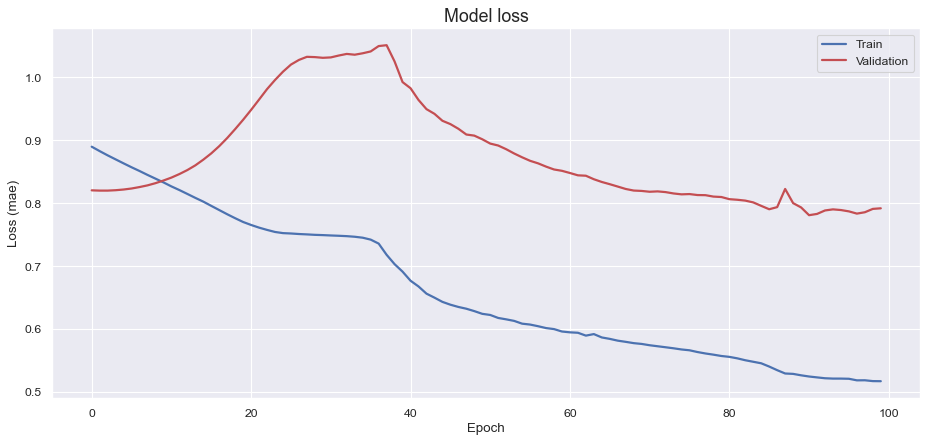

In [63]:
plot_fit(history)

## Confirm anomaly threshold

In [31]:
####################################################################################################
# By plotting the distribution of the calculated loss in the training set, 
# we can determine a suitable threshold value for identifying an anomaly.
## plot the loss distribution of the training set
def pred_mae_train(X_train):
    X_pred= model.predict(X_train)
    X_pred= X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
    X_pred= pd.DataFrame(X_pred, columns= train.columns)
    X_pred.index= train.index

    scored= pd.DataFrame(index= train.index)
    Xtrain= X_train.reshape(X_train.shape[0], X_train.shape[2])
    scored['Loss_mae']= np.mean(np.abs(X_pred - Xtrain), axis=1)
    return scored

def pred_mae_test(X_test):
    X_pred= model.predict(X_test)
    X_pred= X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
    X_pred= pd.DataFrame(X_pred, columns= test.columns)
    X_pred.index= test.index

    scored= pd.DataFrame(index= test.index)
    Xtest= X_test.reshape(X_test.shape[0], X_test.shape[2])
    scored['Loss_mae']= np.mean(np.abs(X_pred - Xtest), axis=1)
    return scored

14/14 [==============================] - 0s 3ms/step


C:\Users\vaiv\AppData\Local\Temp\ipykernel_92052\3885797338.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored['Loss_mae'], bins=20, kde=True, color='blue')


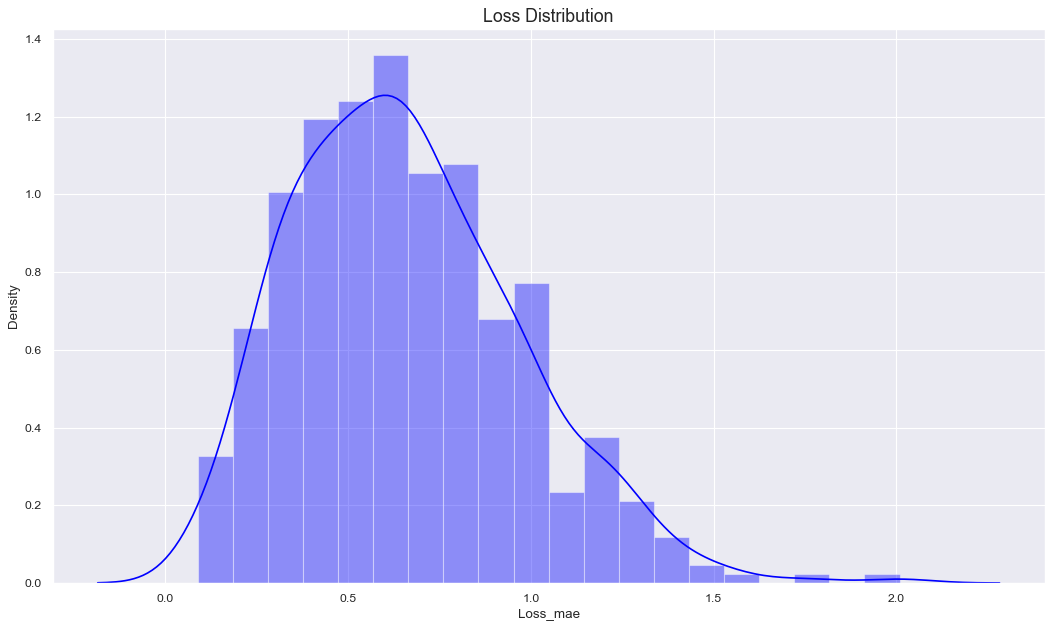

In [33]:
scored= pred_mae_train(X_train)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins=20, kde=True, color='blue')
plt.show()

In [34]:
scored['Loss_mae'].describe()

count    445.000000
mean       0.659990
std        0.308795
min        0.089148
25%        0.431258
50%        0.631584
75%        0.842733
max        2.008367
Name: Loss_mae, dtype: float64

### In training set, maximum of loss of mae is over 2,
### so, we confirm 2.1 as the threshold to flag anomaly.

## Inference

In [88]:
## Calculate the loss on the test set
scored_train= pred_mae_train(X_train)
scored_train['Threshold']= 2.1
scored_train['Anomaly']= scored_train['Loss_mae'] > scored_train['Threshold']

## calculate the same metrics for the training set
## & merge all data in a single dataframe
scored_test= pred_mae_test(X_test)
scored_test['Threshold']= 2.1
scored_test['Anomaly']= scored_test['Loss_mae'] > scored_test['Threshold']
scored= pd.concat([scored_train, scored_test])

17/17 [==============================] - 0s 5ms/step


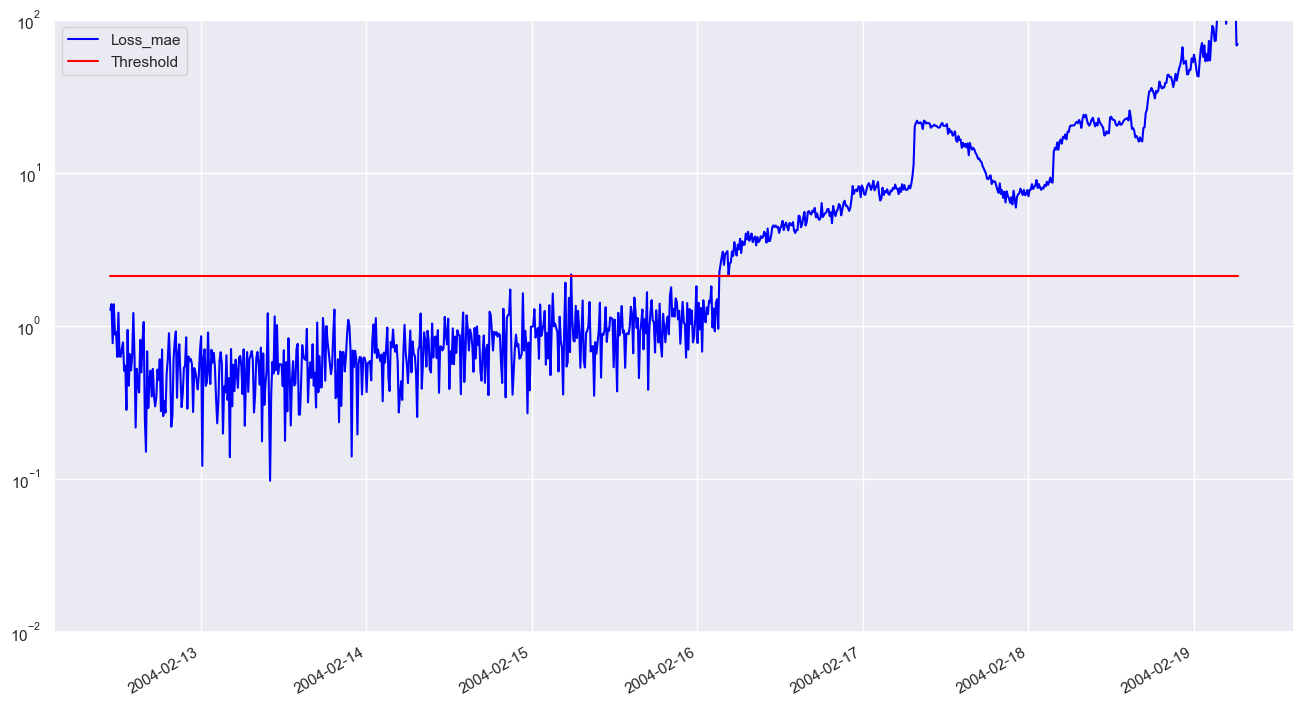

In [89]:
## plot bearing failure timeplot
scored.plot(logy=True, figsize= (16,9), ylim= [1e-2, 1e2], color=['blue', 'red'])
plt.show()

In [90]:
def vis_result(scored):
    anomaly_df= scored[scored.Anomaly == True]
    plt.plot(scored.index, scored.Loss_mae, label='loss_mae')
    plt.scatter(anomaly_df.index, anomaly_df.Loss_mae, label='anomaly_mae', color='red')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

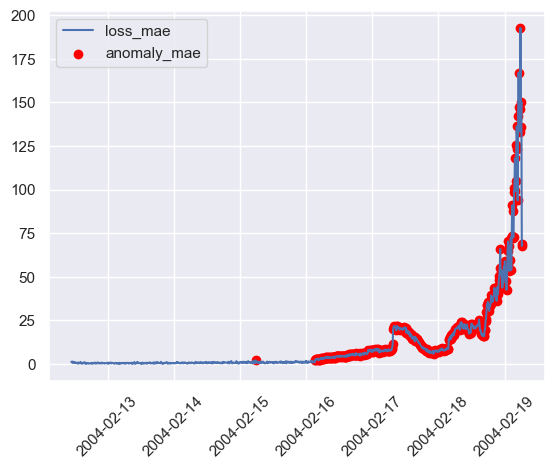

In [91]:
vis_result(scored)